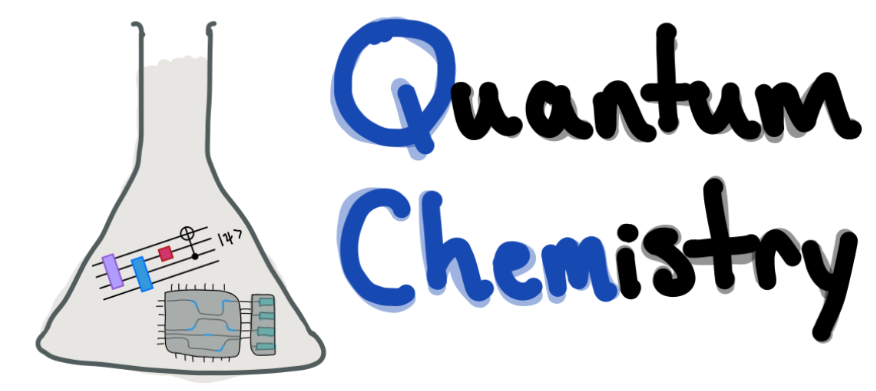

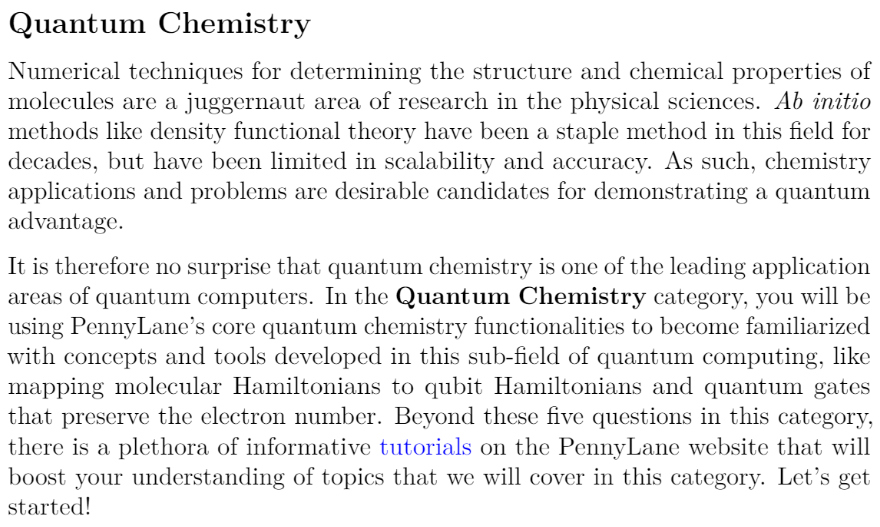

# 100 Points

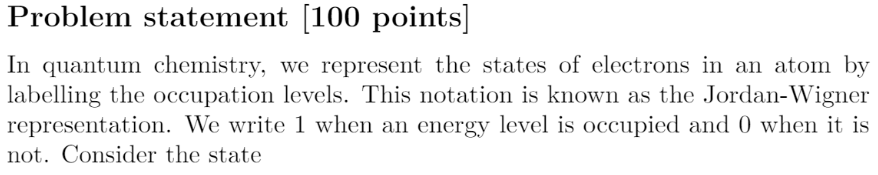

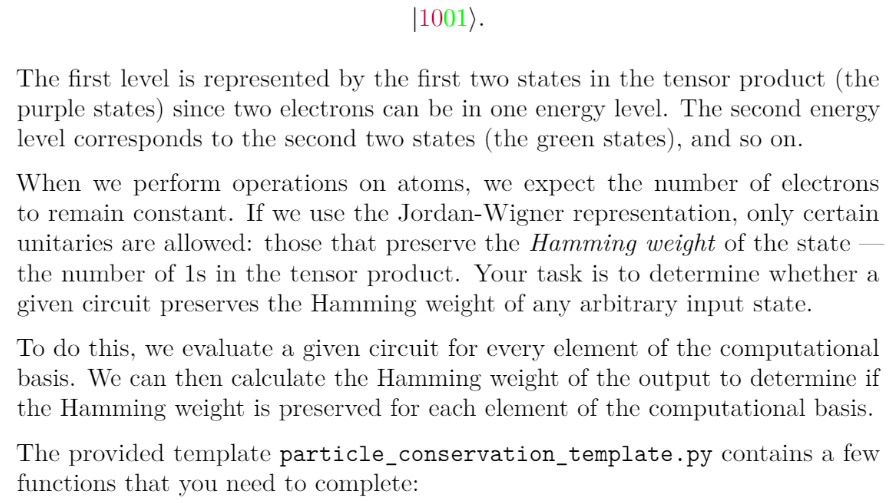

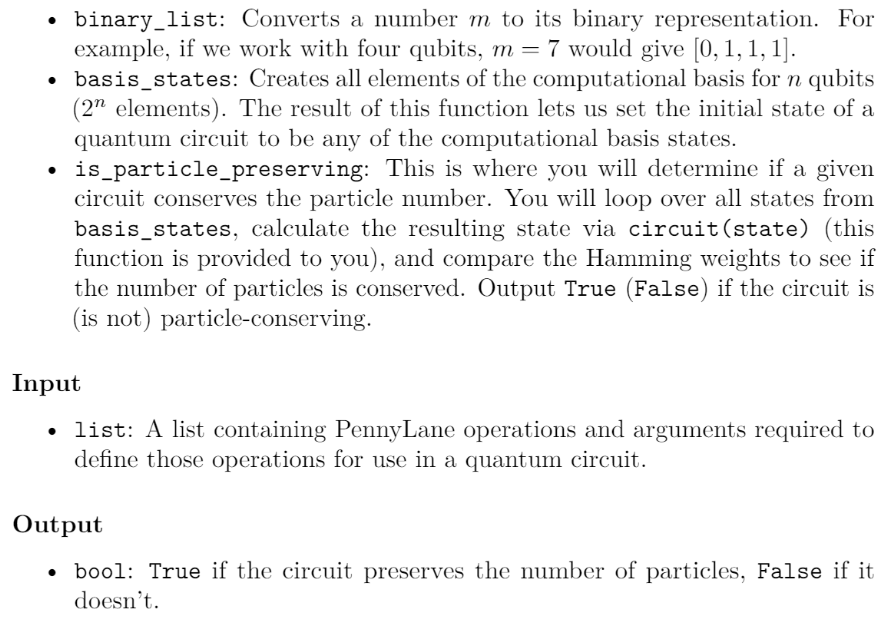

In [1]:
import sys
import pennylane as qml
from pennylane import numpy as np


def binary_list(m, n):
    """Converts number m to binary encoded on a list of length n
    Args:
        - m (int): Number to convert to binary
        - n (int): Number of wires in the circuit
    Returns:
        - (list(int)): Binary stored as a list of length n
    """

    arr = []
    # QHACK #
    str = np.binary_repr(m, width=n)
    for i in range(n):
        arr.append(int(str[i]))

    # QHACK #
    return arr


def basis_states(n):
    """Given a number n, returns a list of all binary_list(m,n) for m < 2**n, thus providing all basis states
         for a circuit of n wires
    Args:
        - n(int): integer representing the number of wires in the circuit
    Returns:
        - (list(list(int))): list of basis states represented as lists of 0s and 1s.
    """

    arr = []

    # QHACK #
    for i in range(2**n):
        arr.append(binary_list(i, n))

    # QHACK #

    return arr


def is_particle_preserving(circuit, n):
    """Given a circuit and its number of wires n, returns 1 if it preserves the number of particles, and 0 if it does not
    Args:
        - circuit (qml.QNode): A QNode that has a state such as [0,0,1,0] as an input and outputs the final state after performing
        quantum operation
        - n (int): the number of wires of circuit
    Returns:
        - (bool): True / False according to whether the input circuit preserves the number of particles or not
    """

    # QHACK #
    bas = basis_states(n)
    tru=[]
    for i in range(2**n):
        final = circuit(bas[i])
        # fin = []
        for j in range(2**n):
            # fin.append(final[j])
            if final[j] != 0:
                m = j
        fin = binary_list(m, n)
        k = bas[i].count(1)
        f = fin.count(1)
        if k == f:
            tru.append(1)
    if len(tru) == 2**n:
        return True
    else:
        return False
    # QHACK #

inputs = '4;DoubleExcitation;0,1,2,3;0.732;SingleExcitation;0,1;1.0'.split(";")

gate_list = []
wire_list = []
param_list = []
i = 1

while i < len(inputs):
    gate_obj = getattr(qml, str(inputs[i]))
    gate_wires = gate_obj.num_wires
    input_wires = list(map(int, str(inputs[i + 1]).split(",")))
    gate_list.append(str(inputs[i]))
    wire_list.append(input_wires)
    if "non_parametric_ops" not in gate_obj.__module__.split("."):
        input_params = list(map(float, str(inputs[i + 2]).split(",")))
        param_list.append(input_params)
        i += 1
    i += 2

wire_list = np.array(wire_list, dtype=object)
param_list = np.array(param_list, dtype=object)

n = int(inputs[0])
dev = qml.device("default.qubit", wires=n)

@qml.qnode(dev)
def circ(gate_list, wire_list, param_list, state):
    qml.BasisState(np.array(state), wires=range(n))
    j = 0
    for i in range(len(gate_list)):
        gate = getattr(qml, str(gate_list[i]))
        if "non_parametric_ops" not in gate.__module__.split("."):
            gate(*param_list[j], wires=[int(w) for w in wire_list[i]])
            j += 1
        else:
            gate(wires=[int(w) for w in wire_list[i]])
    return qml.state()

def circuit(state):
    return circ(gate_list, wire_list, param_list, state)

output = is_particle_preserving(circuit, n)

print('Obtained answer:', output)
print('Expected answer: True')

Obtained answer: True
Expected answer: True


# 200 Points

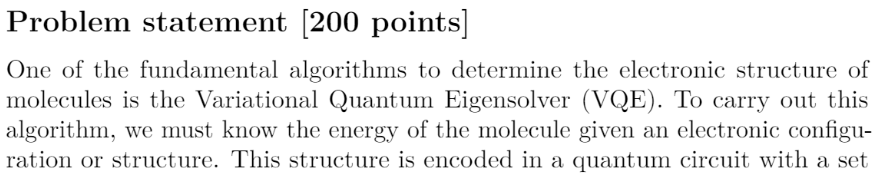

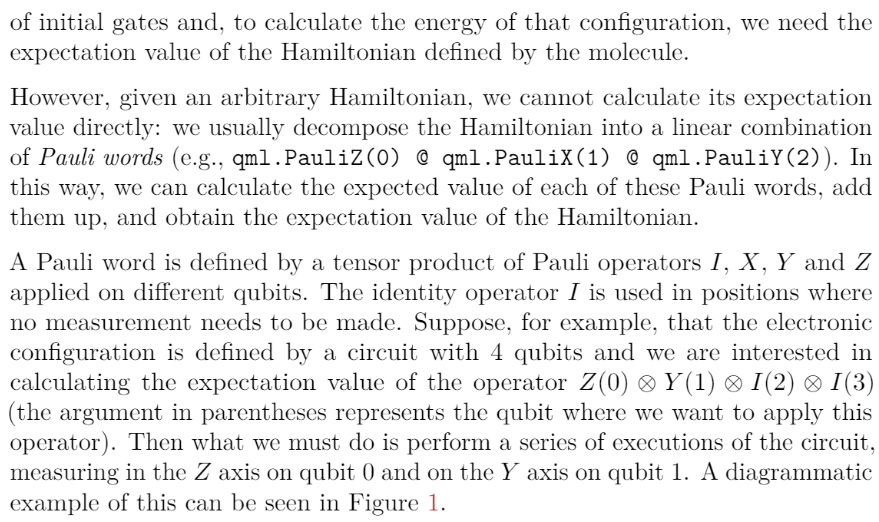

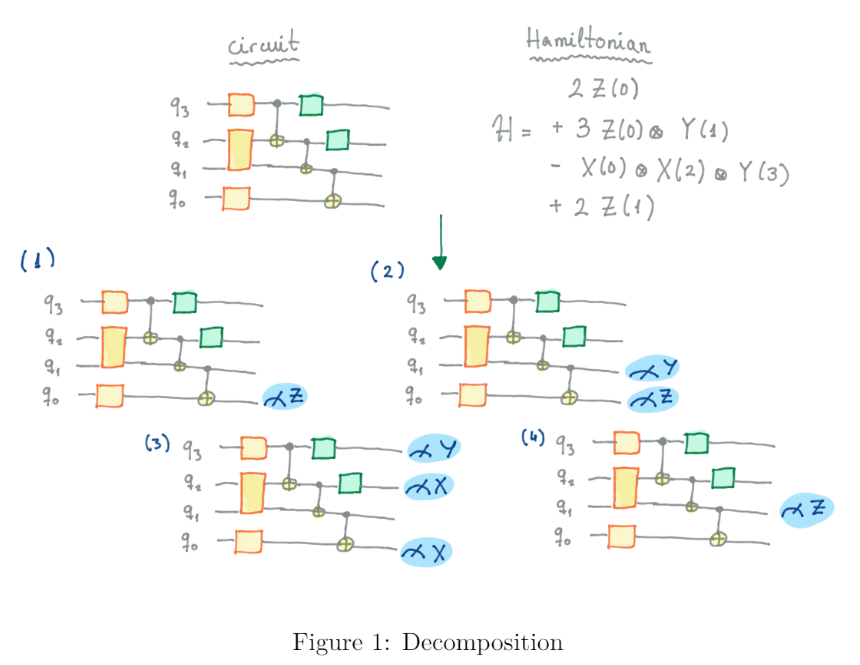

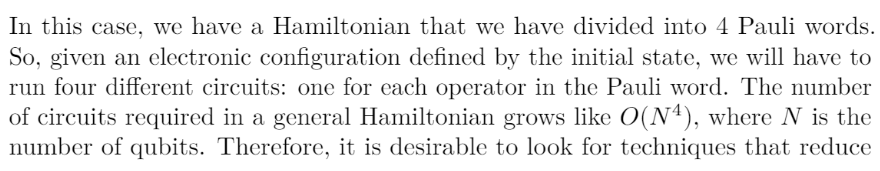

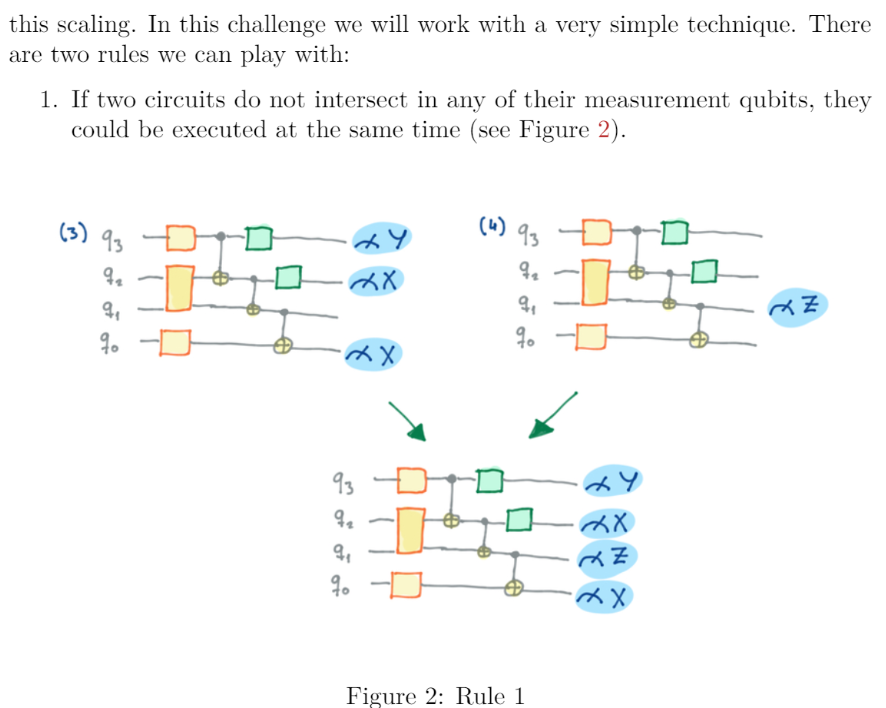

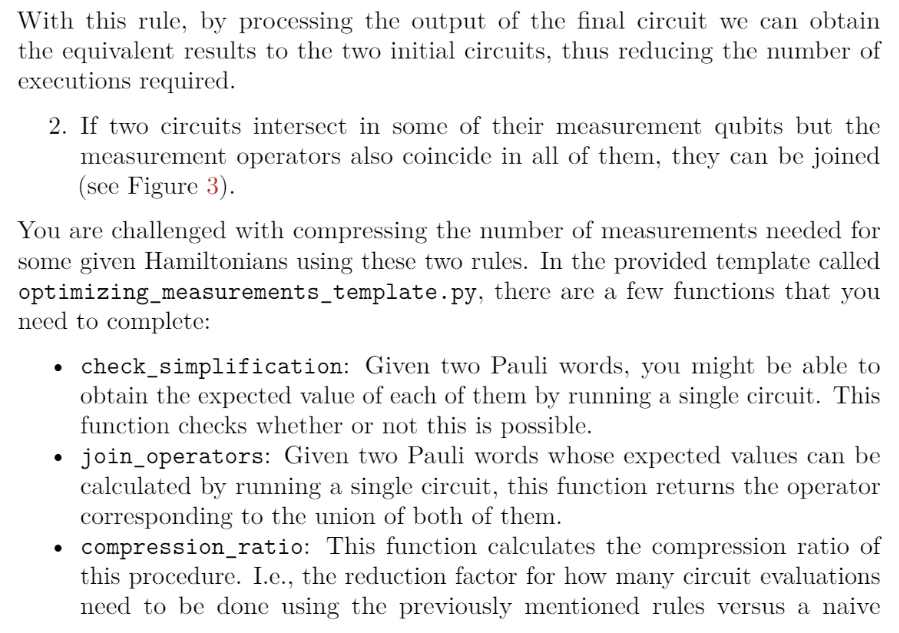

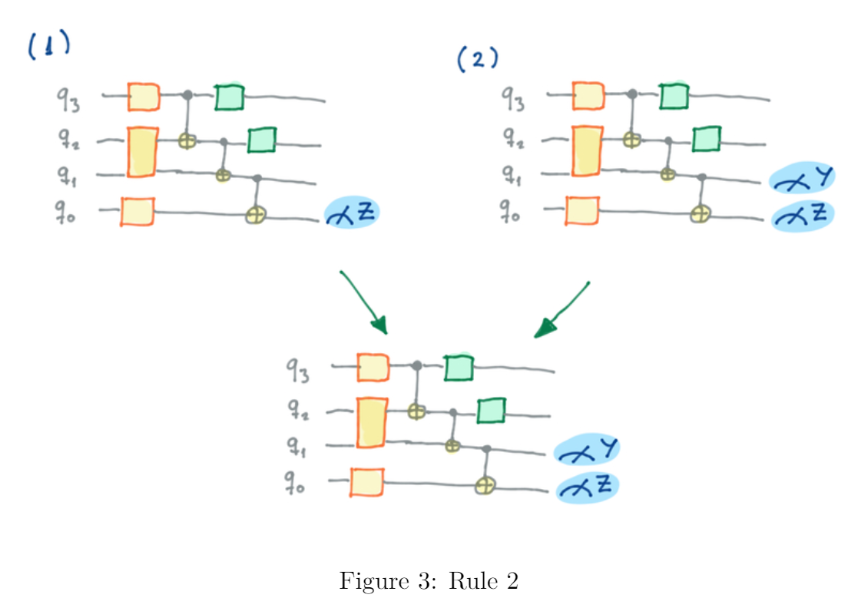

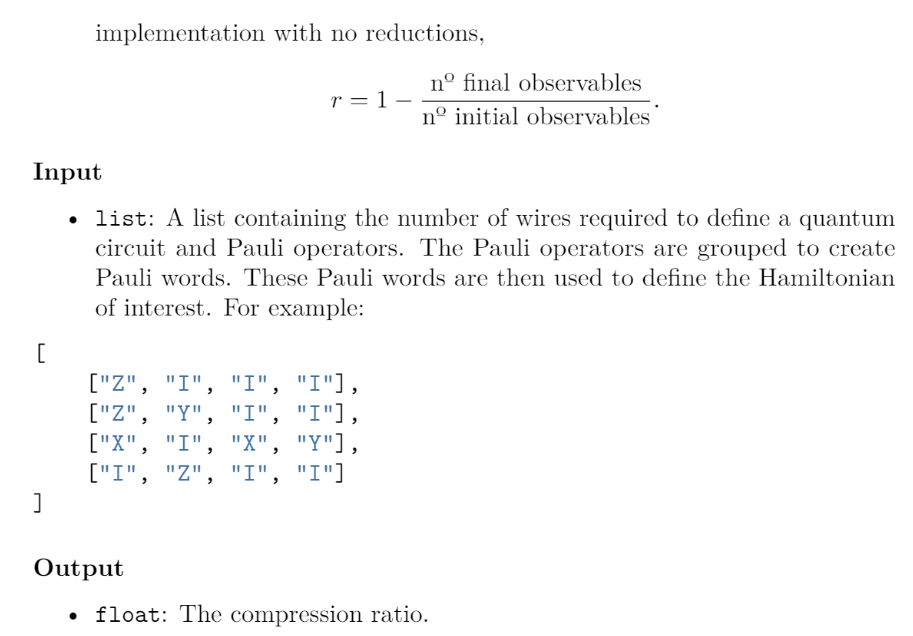

In [3]:
import sys


def check_simplification(op1, op2):
    """As we have seen in the problem statement, given two Pauli operators, you could obtain the expected value
    of each of them by running a single circuit following the two defined rules. This function will determine whether,
    given two Pauli operators, such a simplification can be produced.
    Args:
        - op1 (list(str)): First Pauli word (list of Pauli operators), e.g., ["Y", "I", "Z", "I"].
        - op2 (list(str)): Second Pauli word (list of Pauli operators), e.g., ["Y", "I", "X", "I"].
    Returns:
        - (bool): 'True' if we can simplify them, 'False' otherwise. For the example args above, the third qubit does not allow simplification, so the function would return `False`.
    """

    # QHACK
    k = len(op1)
    c=0
    for i in range(k):
        if op1[i] == op2[i] or op1[i] == "I" or op2[i] == "I":
            c+=1
    if c == k:
        return True
    else:
        return False


    # QHACK


def join_operators(op1, op2):
    """This function will receive two operators that we know can be simplified
    and returns the operator corresponding to the union of the two previous ones.
    Args:
        - op1 (list(str)): First Pauli word (list of Pauli operators), e.g., ["Y", "I", "Z", "I"].
        - op2 (list(str)): Second Pauli word (list of Pauli operators), e.g., ["Y", "X", "I", "I"].
    Returns:
        - (list(str)): Pauli operator corresponding to the union of op1 and op2.
        For the case above the output would be ["Y", "X", "Z", "I"]
    """

    # QHACK
    new = []
    k = len(op1)
    for i in range(k):
        if op1[i] == op2[i]:
            new.append(op1[i])
        if op1[i] == "I" and op2[i] != "I":
            new.append(op2[i])
        if op2[i] == "I" and op1[i] != "I":
            new.append(op1[i])
    return new

    # QHACK


def optimize_measurements(obs_hamiltonian):
    """This function will go through the list of Pauli words provided in the statement, grouping the operators
    following the simplification process of the previous functions.
    Args:
        - obs_hamiltonian (list(list(str))): Groups of Pauli words making up the Hamiltonian.
    Returns:
        - (list(list(str))): The chosen Pauli operators to measure after grouping.
    """

    final_solution = []

    for op1 in obs_hamiltonian:
        added = False
        for i, op2 in enumerate(final_solution):

            if check_simplification(op1, op2):
                final_solution[i] = join_operators(op1, op2)
                added = True
                break
        if not added:
            final_solution.append(op1)

    return final_solution


def compression_ratio(obs_hamiltonian, final_solution):
    """Function that calculates the compression ratio of the procedure.
    Args:
        - obs_hamiltonian (list(list(str))): Groups of Pauli operators making up the Hamiltonian.
        - final_solution (list(list(str))): Your final selection of observables.
    Returns:
        - (float): Compression ratio your solution.
    """

    # QHACK
    n0 = len(obs_hamiltonian)
    n1 = len(final_solution)
    r = 1 - n1/n0
    c = 0
    for i in range(len(final_solution[0])):
        if final_solution[0][i] == "I":
            c+=1
    if c == len(final_solution[0]):
        return 1
    # QHACK
    return r

inputs = '4,Z,X,I,I,Z,Y,I,I,X,I,X,Y,I,Z,I,I'.split(",")

obs_hamiltonian = []
# open file and read the content in a list
aux = []
for i, line in enumerate(inputs):
    if i == 0:
        first = int(line)
    else:
        aux.append(line[0])
        if i % first == 0:
            obs_hamiltonian.append(aux)
            aux = []

output = optimize_measurements(obs_hamiltonian)
print('Obtained answer:', compression_ratio(obs_hamiltonian, output))
print('Expected answer:', 0.25)

Obtained answer: 0.25
Expected answer: 0.25


# 300 Points

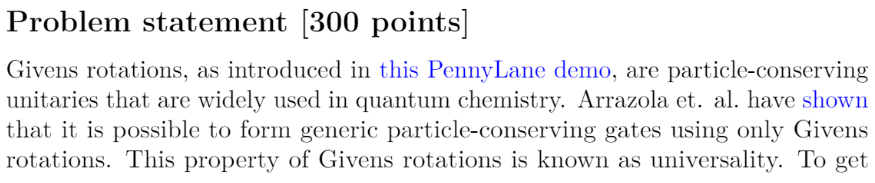

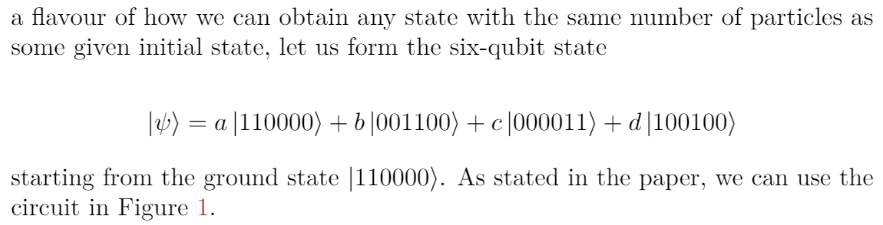

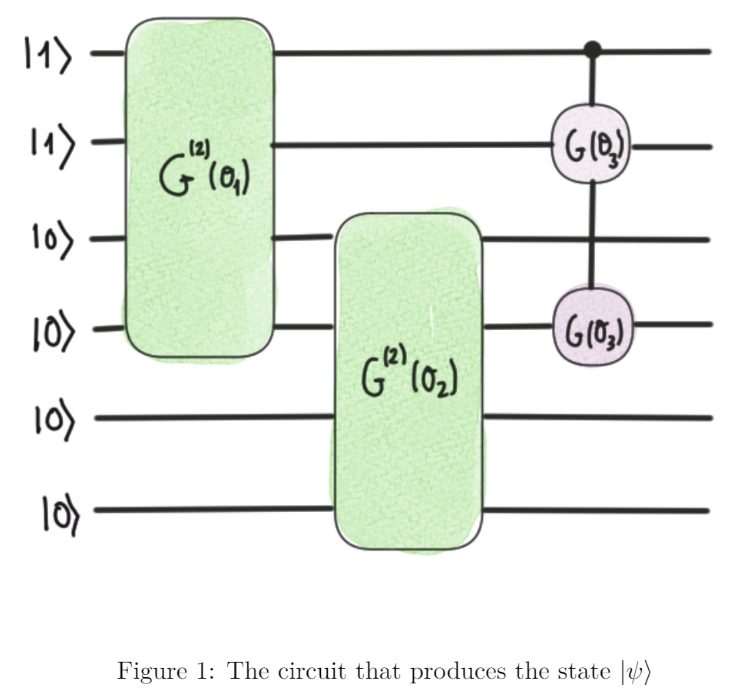

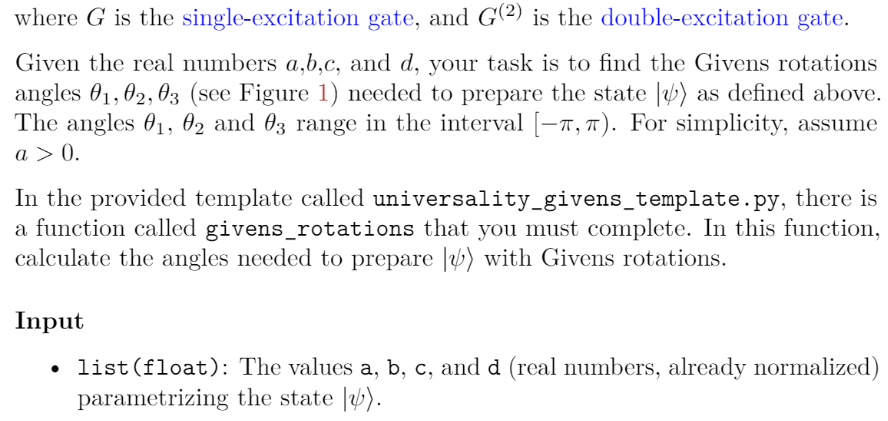

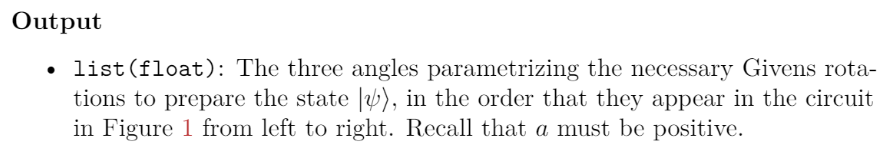

In [5]:
import sys
import numpy as np


def givens_rotations(a, b, c, d):
    """Calculates the angles needed for a Givens rotation to out put the state with amplitudes a,b,c and d
    Args:
        - a,b,c,d (float): real numbers which represent the amplitude of the relevant basis states (see problem statement). Assume they are normalized.
    Returns:
        - (list(float)): a list of real numbers ranging in the intervals provided in the challenge statement, which represent the angles in the Givens rotations,
        in order, that must be applied.
    """

    # QHACK #
    theta_3 = 2*np.arctan(-d/a)
    theta_2 = 2*np.arctan(-c/b)
    theta_1 = 2 * np.arcsin(c / np.sin(theta_2 / 2))
    # QHACK #
    return [theta_1,theta_2,theta_3]



inputs = '0.8062,-0.5,-0.1,-0.3'.split(",")

theta_1, theta_2, theta_3 = givens_rotations(
    float(inputs[0]), float(inputs[1]), float(inputs[2]), float(inputs[3])
)
print('Obtained answer:',[theta_1, theta_2, theta_3])
print('Expected answer: [1.0701416143903084, -0.39479111969976155, 0.7124798514013161]')

Obtained answer: [1.0701416143903084, -0.39479111969976155, 0.7124798514013161]
Expected answer: [1.0701416143903084, -0.39479111969976155, 0.7124798514013161]


# 400 Points

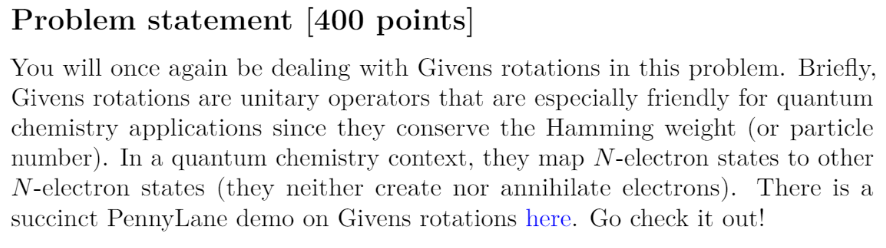

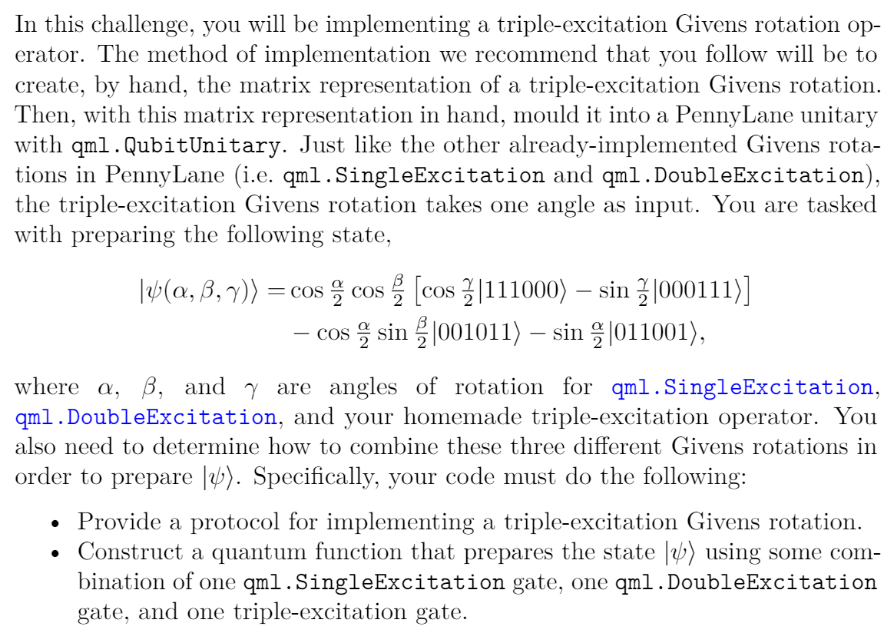

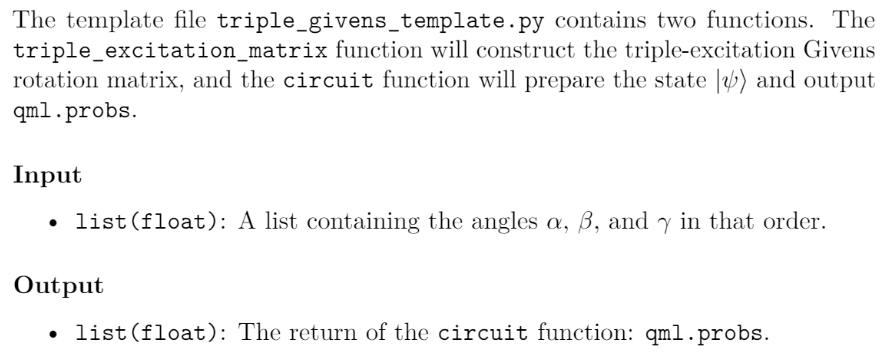

In [11]:
import sys
import pennylane as qml
from pennylane import numpy as np

NUM_WIRES = 6


def triple_excitation_matrix(gamma):
    """The matrix representation of a triple-excitation Givens rotation.
    Args:
        - gamma (float): The angle of rotation
    Returns:
        - (np.ndarray): The matrix representation of a triple-excitation
    """

    # QHACK #
    U = np.identity(2**NUM_WIRES)
    U[7,7] = np.cos(gamma/2)
    U[56,56] = np.cos(gamma/2)
    U[7,56] = -np.sin(gamma/2)
    U[56,7] = np.sin(gamma/2)
    return U

    # QHACK #


dev = qml.device("default.qubit", wires=6)


@qml.qnode(dev)
def circuit(angles):
    """Prepares the quantum state in the problem statement and returns qml.probs
    Args:
        - angles (list(float)): The relevant angles in the problem statement in this order:
        [alpha, beta, gamma]
    Returns:
        - (np.tensor): The probability of each computational basis state
    """

    # QHACK #
    qml.BasisState(np.array([1,1,1,0,0,0]), wires = range(6))
    qml.SingleExcitation(angles[0], wires = [0,5])
    qml.DoubleExcitation(angles[1], wires = [0,1,4,5])
    U = triple_excitation_matrix(angles[2])
    qml.QubitUnitary(U, wires = range(6))

    # QHACK #

    return qml.probs(wires=range(NUM_WIRES))


inputs = np.array('2.53534223,1.48455976,4.31141557'.split(","), dtype=float)

probs = circuit(inputs).round(6)
print('Obtained answer:\n', *probs, sep=",")
print('Expected answer: \n,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033638,0.0,0.0,0.0,0.040715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.910895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014751,0.0,0.0,0.0,0.0,0.0,0.0,0.0')

Obtained answer:
,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033638,0.0,0.0,0.0,0.040715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.910895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014751,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Expected answer: 
,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033638,0.0,0.0,0.0,0.040715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.910895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014751,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 500 Points

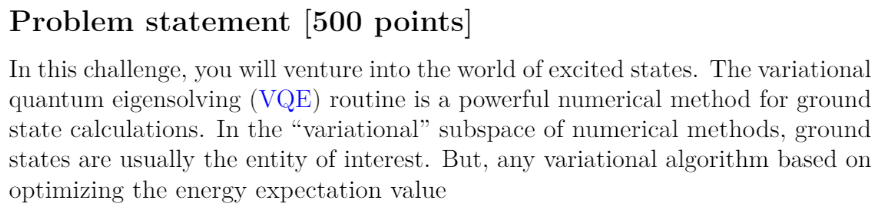

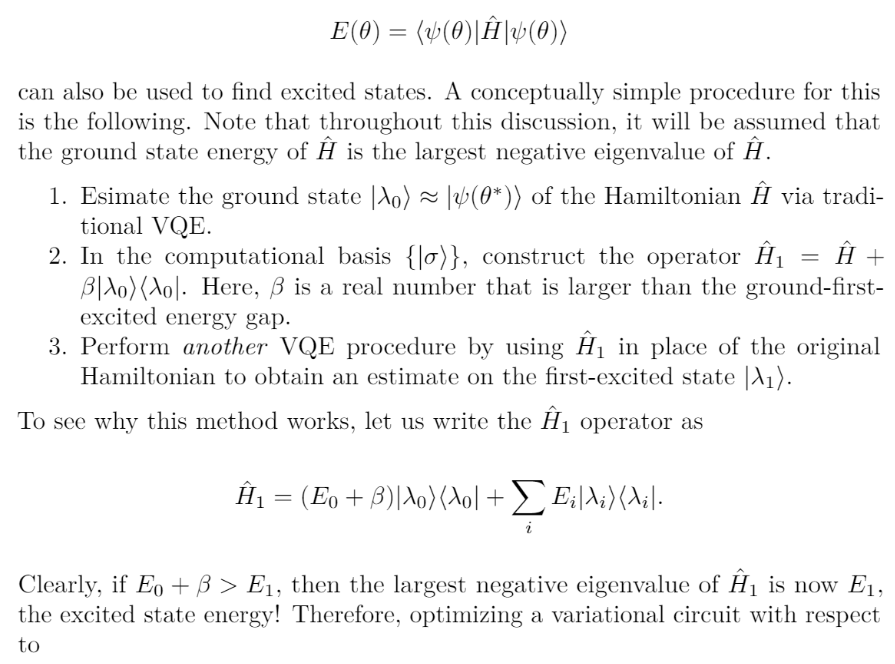

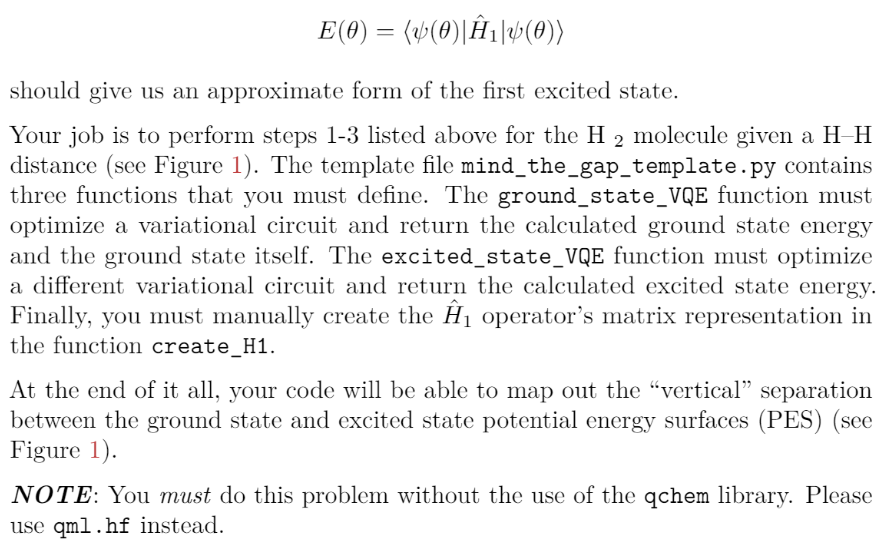

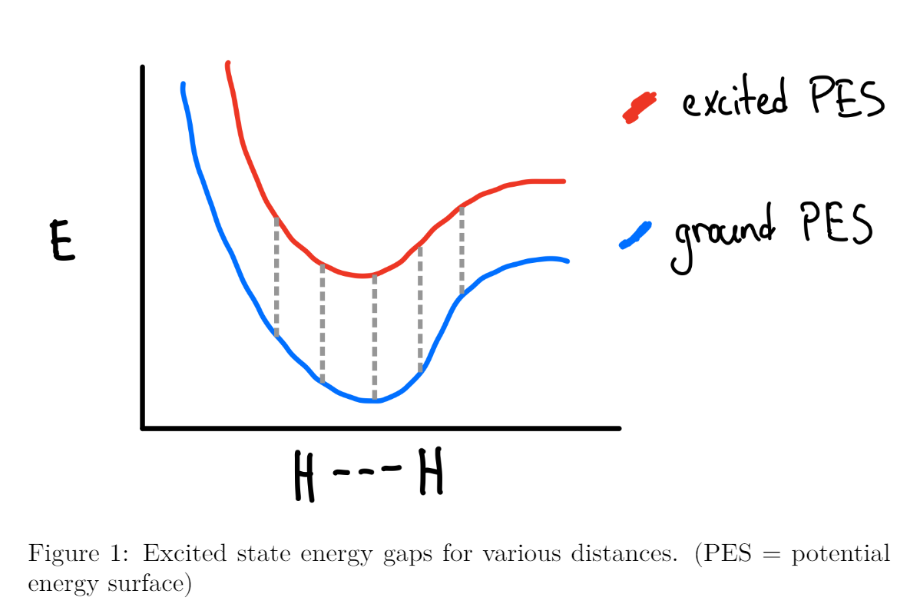

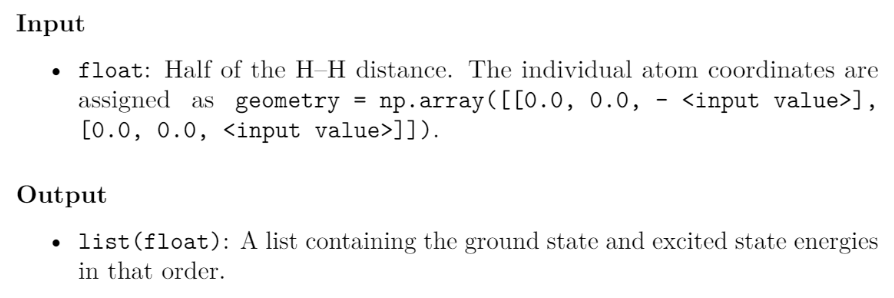

Yes, It's correct


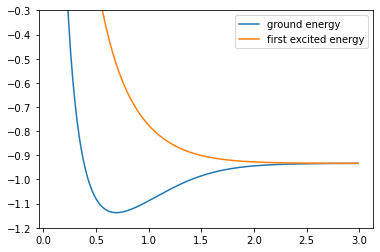

In [13]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import hf
import matplotlib.pyplot as plt

dev = qml.device("default.qubit", wires=4)
dev1 = qml.device("default.qubit", wires=4)


def ground_state_VQE(H):
    """Perform VQE to find the ground state of the H2 Hamiltonian.
    Args:
        - H (qml.Hamiltonian): The Hydrogen (H2) Hamiltonian
    Returns:
        - (float): The ground state energy
        - (np.ndarray): The ground state calculated through your optimization routine
    """

    # QHACK #
    def circuit(param):
        qml.BasisState(np.array([1, 1, 0, 0]), wires=range(4))
        qml.DoubleExcitation(param, wires=[0, 1, 2, 3])

    @qml.qnode(dev)
    def cost_fn(param):
        circuit(param)
        return qml.expval(H)

    # classical optimizer
    opt = qml.GradientDescentOptimizer(stepsize=0.4)
    theta = np.array(0.0, requires_grad=True)
    # store the values of the cost function
    energy = [cost_fn(theta)]

    # store the values of the circuit parameter
    angle = [theta]

    max_iterations = 100
    conv_tol = 1e-06

    for n in range(max_iterations):
        theta, prev_energy = opt.step_and_cost(cost_fn, theta)

        energy.append(cost_fn(theta))
        angle.append(theta)

        conv = np.abs(energy[-1] - prev_energy)
        if conv <= conv_tol:
            break
    gren = energy[-1]
    ang = angle[-1]

    @qml.qnode(dev)
    def statef(ang):
        circuit(ang)
        return qml.state()

    state = statef(ang)
    return gren, state

    # QHACK #


def create_H1(ground_state, beta, H):
    """Create the H1 matrix, then use `qml.Hermitian(matrix)` to return an observable-form of H1.
    Args:
        - ground_state (np.ndarray): from the ground state VQE calculation
        - beta (float): the prefactor for the ground state projector term
        - H (qml.Hamiltonian): the result of hf.generate_hamiltonian(mol)()
    Returns:
        - (qml.Observable): The result of qml.Hermitian(H1_matrix)
    """

    a = ground_state
    a = a[np.newaxis]
    bmatr = beta * a.T.dot(a)

    matrix = qml.utils.sparse_hamiltonian(H, wires=range(4)).real
    matrix = matrix.toarray()
    coeffs, obs_list = qml.utils.decompose_hamiltonian(bmatr)
    Hb = qml.Hamiltonian(coeffs, obs_list)

    return Hb + H


def excited_state_VQE(H1):
    """Perform VQE using the "excited state" Hamiltonian.
    Args:
        - H1 (qml.Observable): result of create_H1
    Returns:
        - (float): The excited state energy
    """


    def circuit1(param1):
        qml.BasisState(np.array([1, 0, 1, 0]), wires=range(4))
        qml.DoubleExcitation(param1, wires=[0, 1, 2, 3])

    @qml.qnode(dev1)
    def cost_fn1(param1):
        circuit1(param1)
        return qml.expval(H1)

    # classical optimizer
    opt = qml.GradientDescentOptimizer(stepsize=0.04)
    theta = np.array(0.0, requires_grad=True)

    # store the values of the cost function
    energy = [cost_fn1(theta)]

    # store the values of the circuit parameter
    angle = [theta]

    max_iterations = 1000
    conv_tol = 1e-06

    for n in range(max_iterations):
        theta, prev_energy = opt.step_and_cost(cost_fn1, theta)

        energy.append(cost_fn1(theta))
        angle.append(theta)

        conv = np.abs(energy[-1] - prev_energy)
        if conv <= conv_tol:
            break
    gren = energy[-1]
    return gren

    # QHACK #
print("Yes, It's correct")

coordinates =  np.arange(0.1, 3, 0.01)
ground = []
excited = []

for coord in coordinates:  
    symbols = ["H", "H"]
    geometry = np.array([[0.0, 0.0, -coord], [0.0, 0.0, coord]], requires_grad=False)
    mol = hf.Molecule(symbols, geometry)
    
    H = hf.generate_hamiltonian(mol)()
    E0, ground_state = ground_state_VQE(H)
    
    beta = 20000
    H1 = create_H1(ground_state, beta, H)
    E1 = excited_state_VQE(H1)
    ground.append(E0)
    excited.append(E1)

fig = plt.figure()
plt.plot(coordinates, ground, label = 'ground energy')
plt.plot(coordinates, excited, label = 'first excited energy')
plt.ylim(-1.2, -0.3)
plt.legend()
plt.show()
